In [1]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

In [39]:
import torch.nn as nn

def local_avg(imgs):
    layer = nn.AvgPool2d((3, 3), stride=1, padding = 1)
    outs = imgs.clone().detach().permute((0, 3, 1, 2))
    outs = layer(outs).permute((0, 2, 3, 1))
    return outs

def local_maximum(imgs):
    layer = torch.nn.MaxPool2d(kernel_size = (3,3), stride = 1, padding = 1)
    outs = imgs.clone().detach().permute((0, 3, 1, 2))
    outs = layer(outs).permute((0, 2, 3, 1))
    return outs

In [2]:
def load():
    download_root = 'data/emnist_dataset'
    
    temp = EMNIST(download_root, split = 'letters', train=True, download=True)
    x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y = temp.targets.numpy() - 1
    temp = EMNIST(download_root, split='letters', train=False, download=True)
    x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_test = temp.targets.numpy() - 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    x_test = x_test.float()
    y_test = y_test.long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

In [4]:
x, x_test, y, y_test = load()

In [8]:
x = x.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))
x = torch.tensor(scaler.transform(x.reshape(-1, 784)))
x_test = torch.tensor(scaler.transform(x_test.reshape(-1, 784)))

In [9]:
classes = y.unique().size(0)
features = x.size(1)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
x_avg = local_avg(x.reshape(-1, 28, 28, 1))
x_avg = x_avg.reshape(-1, 784)
model = model.fit(x_avg, y, bootstrap=1.0, lr=0.035, epochs=100)
t = time() - t

Training...
0
10
20
30
40
50
60
70
80
90


In [10]:
x_avg_test = local_avg(x_test.reshape(-1, 28, 28, 1))
x_avg_test = x_avg_test.reshape(-1, 784)

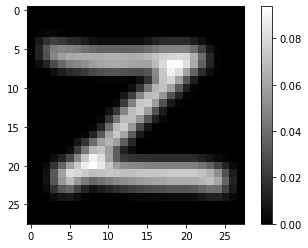

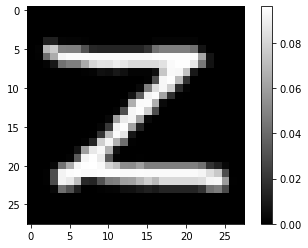

In [19]:
plt.imshow(x_avg_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [11]:
print('Validating...')
yhat = model(x_avg)
yhat_test = model(x_avg_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.931643
acc_test = 0.892404
t = 279.328211


In [16]:
import pickle

with open('hd_adversarial_sample/EMNIST_HD_JSMA.pickle', 'rb') as f:
    data3 = pickle.load(f)
    JSMA = data3['data']
    LABEL = data3['label']
    
with open('hd_adversarial_sample/EMNIST_HD_DF.pickle', 'rb') as f:
    data2 = pickle.load(f)
    DF = data2['data']
    
import pickle 

with open('hd_adversarial_sample/EMNIST_HD_FGSM.pickle', 'rb') as f:
    data = pickle.load(f)
    FGSM001 = data['data']['0.01']
    FGSM003 = data['data']['0.03']
    FGSM007 = data['data']['0.07']
    FGSM01 = data['data']['0.1']

In [30]:
def show(dataset, name):
    tmp = dataset.reshape(-1, 28, 28, 1)
    tmp = local_avg(tmp)
    pred = model(tmp.reshape(-1, 784))
    print(name, ' : ', sum(pred == y_test)/ len(y_test))
    plt.imshow(tmp[-1].reshape(28, 28), cmap='gray')
    plt.title(name)
    plt.colorbar()
    plt.show()

FGSM001  :  tensor(0.8432)


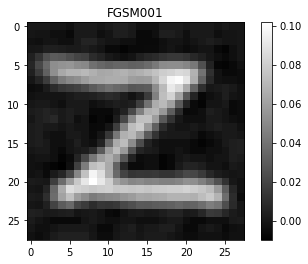

FGSM003  :  tensor(0.5714)


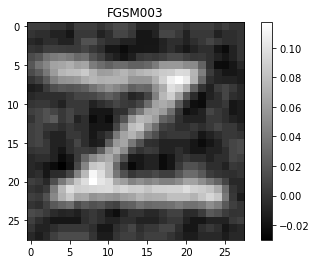

FGSM007  :  tensor(0.0992)


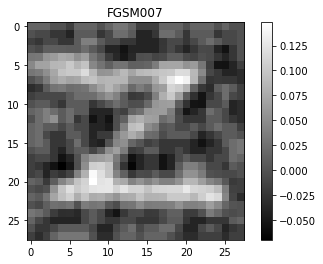

FGSM01  :  tensor(0.0419)


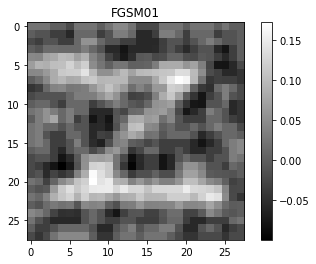

DF  :  tensor(0.8568)


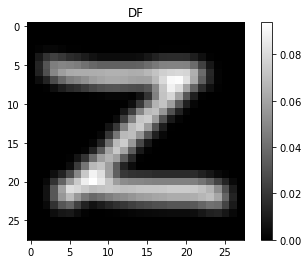

JSMA  :  tensor(0.8117)


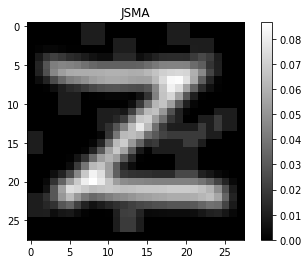

In [31]:
show(FGSM001, 'FGSM001')
show(FGSM003, 'FGSM003')
show(FGSM007, 'FGSM007')
show(FGSM01, 'FGSM01')
show(DF, 'DF')
show(JSMA, 'JSMA')